# Глава I: экстрактивное аннотирование

In [ ]:
!wget https://drive.google.com/drive/folders/15lciCVCPwazFPle2g_jWx3GtwdJ_nTBR

--2023-09-27 11:42:13--  https://drive.google.com/drive/folders/15lciCVCPwazFPle2g_jWx3GtwdJ_nTBR
Resolving drive.google.com (drive.google.com)... 173.194.69.138, 173.194.69.113, 173.194.69.101, ...
Connecting to drive.google.com (drive.google.com)|173.194.69.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘15lciCVCPwazFPle2g_jWx3GtwdJ_nTBR.1’

15lciCVCPwazFPle2g_     [ <=>                ] 267.88K  --.-KB/s    in 0.1s    

2023-09-27 11:42:13 (2.01 MB/s) - ‘15lciCVCPwazFPle2g_jWx3GtwdJ_nTBR.1’ saved [274313]



In [ ]:
!pip install datasets
!pip install transformers
!pip install sentence_transformers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Загружаем данные

Библиотека **Hugging Face Datasets** предназначена для легкой загрузки и обработки данных (в т.ч. есть встроенная поддержка параллельной обработки записей). Поддерживаются все типы данных и большинство современных форматов. Основная филосифия - эффективность работы, поэтому перед работой с данными они кэшируется в бинарном виде для последующей ленивой загрузки батчами в асинхронном режиме.

In [ ]:
import datasets
from pathlib import Path
import random

# ПОМЕНЯТЬ ЗДЕСЬ ПУТЬ ДЛЯ ЗАГРУЗКИ С ГУГЛ ДИСКА
PROJECT_DATA_DIR=Path("drive/MyDrive/Academy")

DATA_DIR = PROJECT_DATA_DIR / "data"

CACHE_DIR = Path("./cache")

data_name = "ru_news"  # "news_and_summaries"
data = datasets.load_dataset("json", data_files={f"{split}": (
    DATA_DIR / f"{data_name}.{split}").as_posix() for split in ["train", "test"]}, cache_dir=CACHE_DIR.as_posix())

Данные разбиты на обучающую **(train)** и тестовую **(test)** подвыборки

Каждый пример состоит из:
* документа **(document)** разбитого на предложения
* списка наиболее репрезентативных предложений **(most_important_sentences)**
* номера кластера **(cluster_id)**
* аннотации **(cluster_summary)**

Рассмотрим пример:

In [ ]:
data['train'][0]

{'document': ['Грузовой самолет Boeing 737 упал в воду у побережья Гонолулу 2 июля.',
  'Как передает американский телеканал CNBC, причиной ЧП стала неисправность двигателя.',
  'По его данным, вскоре после взлета у самолета начались технические неполадки.',
  'Он развернулся, чтобы возвратиться в аэропорт в Гонолулу, но не долетел.',
  'На борту находились два пилота – им пришлось произвести экстренную посадку воздушного судна на воду.',
  '«В полете сообщалось о выходе из строя двигателя №1 и затруднениях с поддержанием высоты.',
  'Из-за невозможности увидеть аэропорт экипажу были даны указания.',
  'После того, как поступило предупреждение о малой высоте полета, диспетчер предложил направиться в аэропорт Калаэлоа, который находился ближе.',
  'Самолет не смог добраться до аэропорта», - передает портал aviation-safety.net.',
  'Оба находившихся в самолете пилота спасены.',
  'Одного из них госпитализировали, сообщили в министерстве транспорта США.',
  'В свою очередь, в Федеральном 

## Часть 1: позиционный бейслайн

### Задание 1.1: визуализировать most_important_sentences

Экстрактивное аннотирование - задача классификация фрагментов текста. В данном случае классифицируем предложения по принципу важное/неважное. Обычно такой разметки нет и приходится обходиться различными эвристиками, но, к счастью, в наших данных есть пользовательская разметка **most_important_sentences**.

Давайте попробуем построить гистограмму

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
def convert_split_labels_to_list_of_positions(split):
    res = []

    for label in split:
      res.extend(label["most_important_sentences"])

    return res

(array([962., 609., 477., 447., 379., 333., 320., 266., 241., 210., 171.,
        157., 128.,  97.,  83.,  54.,  44.,  12.,  15.,   7.]),
 array([ 0.  ,  1.95,  3.9 ,  5.85,  7.8 ,  9.75, 11.7 , 13.65, 15.6 ,
        17.55, 19.5 , 21.45, 23.4 , 25.35, 27.3 , 29.25, 31.2 , 33.15,
        35.1 , 37.05, 39.  ]),
 <BarContainer object of 20 artists>)

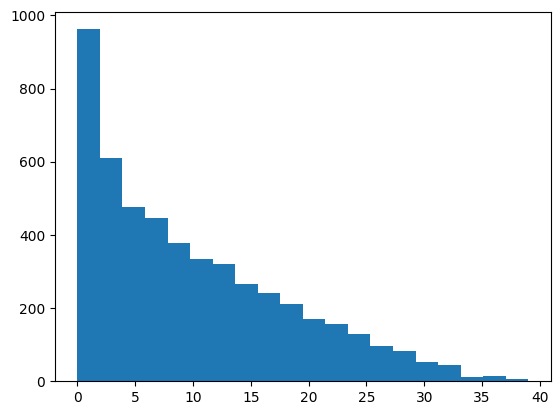

In [ ]:
important_sentence_positions = convert_split_labels_to_list_of_positions(
    data["train"])
plt.hist(important_sentence_positions, bins=20)

### Задание 1.2: на основе гистогаммы выше придумайте позиционную стратегию выбора предложений

*Hint:* попробуйте с нормализацией по длине документа (в предложениях) и без

In [ ]:
import random

def positional_baseline(example, **kwargs):
    important_positions = []

    # Получаем длины предложений
    sentence_lengths = [len(sentence.split()) for sentence in example['document']]

    # Нормализация по длине документа
    normalized_lengths = [length / sum(sentence_lengths) for length in sentence_lengths]

    # Выбираем позиции на основе нормализованных длин
    threshold = 0.045  # Порог для определения важных предложений
    for i, length in enumerate(normalized_lengths):
        if length > threshold:
            important_positions.append(i)

    return important_positions

In [ ]:
example_id = random.randint(0, len(data['train']))
example = data['train'][example_id]

extractive_prediction = positional_baseline(example)

document_text = " ".join(example['document'])
summary = " ".join(example['document'][sent_id]
                   for sent_id in extractive_prediction)
print("***ТЕКСТ СТАТЬИ:***", f"{document_text}\n", sep='\n\n')
print("***ТЕКСТ ПРЕДСКАЗАННОЙ АННОТАЦИИ:***", f"{summary}\n", sep='\n\n')

***ТЕКСТ СТАТЬИ:***

В Туве, Ингушетии и Кабардино-Балкарии по итогам 2020 года зафиксирован наибольший уровень бедности населения. Об этом сообщил замдиректора департамента информационных технологий Минтруда Андрей Лебедев, ссылаясь на данные Росстата, передает ТАСС. Уровень бедности высчитывается как доля населения с доходами ниже прожиточного минимума к общему числу граждан, проживающих в регионе. В Туве таких жителей 34,1%. В Ингушетии, расположившейся на втором месте, их 30%. Третья позиция антирейтинга у Кабардино-Балкарии — там уровень бедности составляет 24,2%. Кроме того, относительно высокий уровень бедности Росстат зарегистрировал в Республике Алтай — более 23%. Меньше всего доля бедного населения (от 5% до 10%) в Москве, Санкт-Петербурге, Подмосковье, Калужской, Ленинградской, Нижегородской, Курской, Белгородской, Воронежской, Свердловской, Ярославской, Магаданской и Сахалинской областях, Татарстане, Ямало-Ненецком, Ханты-Мансийском и Чукотском автономном округах. Лебедев з

## Часть 2: TF-IDF + MMR

In [ ]:
# "eng-com_web-public_2018_1M-words.txt"
CORP_NAME = "rus-ru_web-public_2019_1M-words.txt"


def read_word_corpora():
    with open(DATA_DIR / CORP_NAME) as f:
        return dict((pair[0], int(pair[1])) for l in f if (pair := l.strip().split('\t')[1:]))

### Задание 2.1: частотная векторизация TF-IDF

Самый простой способ векторизации текста - составить вектор частот употребления его слов. Но вот незадача: по закону ципфа самые частотные слова это частицы, союзы или местоимения, то есть неинформативные служебные слова! Можно выбросить служебные слова, но что делать с частотными терминами, которые также не несут смысла, например "мужщина" и "женщина"?

Решение - формула нормализации частот **TF-IDF**:
$$\text{TF-IDF}(w_i, document_k)=\text{TF}(w_i, doc_k)\cdot \text{IDF}(w_i,DOCS)$$

$TF$ - частота термина:
$$\text{TF}(w_i, doc_k)=\text{frequency}(w_i, doc_k)$$

$IDF$ - обратная частота встречаемости термина в документах, нормировачный коэффициент:
$$\text{IDF}(w_i,DOCS)=\log{\frac{|DOCS|}{|\{doc_j \in DOCS : w_i \in doc_j \}|+1}}$$

Вам дан словарь документных частот **raw_word_df**. Напишите функцию вычисления TF-IDF.

In [ ]:
import re

def simple_tokenize(text):
    tokens = text.split()
    return tokens

In [ ]:
from collections import Counter
import numpy as np


class TfIdfVectorizer:
    def __init__(self, df_dict=None, tokenizer=simple_tokenize):
        if df_dict is None:
            df_dict = read_word_corpora()
        self.df_dict = df_dict
        self.tokenizer = tokenizer
        self.df_idx_dict = {word: idx for idx,
                            word in enumerate(df_dict.keys())}

    def tf_idf_word(self, word, word_count):
        tfidf = word_count * np.log(max(self.df_dict.values()) / (self.df_dict[word] + 1))
        return tfidf

    def tf_idf_text(self, text):
        # default vector
        tfidf_vector = np.zeros(len(self.df_idx_dict))

        # words_and_counts=[("",0)]
        """"""
        words_and_counts = Counter(self.tokenizer(text))
        words_and_counts = list(words_and_counts.items())

        # Tokenize and count freqs

        for word, count in words_and_counts:
            if word in self.df_idx_dict:
                tfidf_vector[self.df_idx_dict[word]
                             ] = self.tf_idf_word(word, count)
        return tfidf_vector

    def __call__(self, text):
        return self.tf_idf_text(text)

In [ ]:
raw_word_df = read_word_corpora()

vectorizer = TfIdfVectorizer(df_dict=raw_word_df)

test_vector = vectorizer(document_text)
print("Вектор:\n", test_vector)
print("Плотность:\n {:.5%}".format(
    len(test_vector.nonzero())/test_vector.shape[-1]))
print("Уникальные значения:\n", np.unique(test_vector))

Вектор:
 [0. 0. 0. ... 0. 0. 0.]
Плотность:
 0.00013%
Уникальные значения:
 [-8.10877763e-07  0.00000000e+00  2.68231133e+00  2.93036275e+00
  3.35663468e+00  3.43901836e+00  3.61138509e+00  3.69240007e+00
  3.80933466e+00  3.93680056e+00  4.02785151e+00  4.05493693e+00
  4.06098888e+00  4.17786061e+00  4.18454711e+00  4.18518626e+00
  4.23561344e+00  4.28612255e+00  4.35101083e+00  4.42438859e+00
  4.46355339e+00  4.61489188e+00  4.68018944e+00  4.84495772e+00
  4.85928223e+00  4.89082523e+00  4.92775250e+00  4.96504940e+00
  5.16592672e+00  5.21558386e+00  5.26453826e+00  5.38821824e+00
  5.43492978e+00  5.47336028e+00  5.53142828e+00  5.62045195e+00
  5.68732085e+00  5.71448721e+00  5.81911035e+00  5.92741754e+00
  5.92772181e+00  5.93290871e+00  5.93812264e+00  6.03668539e+00
  6.03711673e+00  6.04273177e+00  6.07838918e+00  6.08884542e+00
  6.15651122e+00  6.15765954e+00  6.16921591e+00  6.19790721e+00
  6.24235150e+00  6.25873121e+00  6.26438958e+00  6.26980930e+00
  6.29585244e+

### Задание 2.2: Оценка важности предложений по TF-IDF

В основе TF-IDF лежит идея, что частотные слова будут штрафоваться, а редкие термины, наоборот, получат максимальный вес. С другой стороны, важные предложения текста скорее всего будут богаты сущностями и ключевыми словами, а они в силу своей природы часто лежат в хвосте распределения частот слов языка, то есть имеют максимальные коэффициент IDF. Тогда можно оценить важность предложения как сумму TF-IDF его слов.

In [ ]:
def tfidf_sum(sentence_embeddings: np.ndarray, topk: int = None):
    ranking = []

    for i, sentence_embedding in enumerate(sentence_embeddings):
        tfidf_score = np.sum(sentence_embedding)
        ranking.append((i, tfidf_score))

    ranking = sorted(ranking, key=lambda x: x[1], reverse=True)
    ranking = [idx for idx, _ in ranking]

    return ranking[:topk]


In [ ]:
sent_embs = np.stack([vectorizer(sent) for sent in example['document']])

extractive_prediction = tfidf_sum(sentence_embeddings=sent_embs, topk=3)

# Нужно для связности аннотации
# extractive_prediction = [idx for idx, _ in extractive_prediction]
extractive_prediction = sorted(extractive_prediction)

summary = " ".join(example['document'][sent_id]
                   for sent_id in extractive_prediction)
print("***ТЕКСТ ПРЕДСКАЗАННОЙ АННОТАЦИИ:***", f"{summary}\n", sep='\n\n')

***ТЕКСТ ПРЕДСКАЗАННОЙ АННОТАЦИИ:***

Выходом из подобной ситуации, по мнению чиновника, является построение в регионе экономической политики, когда молодые специалисты могут максимально эффективно применять свои навыки при трудоустройстве. Средний прожиточный минимум в России сейчас составляет 11,6 тыс. руб. (12,7 тыс. для трудоспособных граждан, 11,3 тыс. для детей, 10 тыс. для пенсионеров). Глава Счетной палаты Алексей Кудрин в интервью РБК говорил , что ценой в несколько сотен миллиардов рублей в год можно создать модель, позволяющую снизить бедность в России вдвое.



### Задание 2.3: оптимизация TF-IDF

Выше приведена классическая реализация TF-IDF. В ней проссматриваются 3 основных проблемы:
* неизвестные слова игнорируются/переоцениваются
* теряется связь между однокоренными словами
* выходной вектор **крайне** разреженный

**Решение**: предобработка и нормализация. В современном мире это делается статистическими токенизаторами на основе алгоритмов WordPiece/SentencePiece или BPE.

Токенизатор для нормализации уже выбран за Вас.

Вам необходимо применить его к словарю и придумать функцию предобработки строк для минимизации размера нового словаря частот.

In [ ]:
from transformers import BertTokenizerFast, AutoTokenizer

ENCODER_MODEL_PATH =  PROJECT_DATA_DIR / "models/rubert-tiny2/"

bpe_tokenizer = AutoTokenizer.from_pretrained(ENCODER_MODEL_PATH)

bpe_tokenizer.tokenize("Ложка")

['Ло', '##жка']

In [ ]:
from typing import List, Set, Dict
from collections import defaultdict


def normalize_and_tokenize(text: str, base_tokenization_func=None, normalize: bool = True) -> List[str]:
    normalized_text = text
    if normalize:
        normalized_text = " ".join(bpe_tokenizer.tokenize(normalized_text))
    tokens = [normalized_text]
    if base_tokenization_func is not None:
        tokens = base_tokenization_func(normalized_text)
    return tokens


def get_possible_token_list(token_list: List[str], new_tokenization_func=None) -> List[str]:
    filtered_token_list = token_list
    if new_tokenization_func is not None:
        filtered_token_list = []
        for i in token_list:
            filtered_token_list.extend(new_tokenization_func(i))
    return filtered_token_list


def convert_df_dict_to_tokenizer(idf_dict: Dict[str, int], new_token_list: List[str], tokenization_func):
    converted_df_dict = defaultdict(lambda: 0, ((k, 0) for k in new_token_list))
    # total_tokens = len(new_token_list)

    for token, idf_freq in idf_dict.items():
        tokenized = tokenization_func(token)
        # num_subtokens = len(tokenized) if isinstance(tokenized, list) else 1
        # token_freq = idf_freq / num_subtokens
        token_freq = idf_freq

        # Распределение частоты по токенам
        for subtoken in tokenized:
            # converted_df_dict[subtoken] += token_freq / total_tokens
            converted_df_dict[subtoken] += token_freq

    return converted_df_dict

In [ ]:
from functools import partial


better_tokenizer = partial(normalize_and_tokenize,
                           base_tokenization_func=bpe_tokenizer.tokenize)

# Исходные токены словаря могут быть в нечитаемом/искаженном виде, поэтому нужно сначала привести их в естественную форму
new_tokens = [bpe_tokenizer.convert_tokens_to_string([token]) for token in
              bpe_tokenizer.get_vocab().keys() if token not in bpe_tokenizer.all_special_tokens]

possible_tokens = get_possible_token_list(new_tokens, better_tokenizer)
print("Possible tokens count:", len(possible_tokens))

new_df_dict = convert_df_dict_to_tokenizer(
    raw_word_df, possible_tokens, better_tokenizer)

print("Reduced the size of DF dict by {:.2%}".format(
    1 - len(new_df_dict)/len(raw_word_df)))

Possible tokens count: 158768
Reduced the size of DF dict by 90.62%


In [ ]:
better_vectorizer = TfIdfVectorizer(
    df_dict=new_df_dict, tokenizer=better_tokenizer)

test_vector = better_vectorizer(document_text)
print("Вектор:\n", test_vector)
print("Плотность:\n {:.5%}".format(
    len(test_vector.nonzero())/test_vector.shape[-1]))
print("Ненулевые значения:\n", np.unique(test_vector))

Вектор:
 [0. 0. 0. ... 0. 0. 0.]
Плотность:
 0.00143%
Ненулевые значения:
 [-1.50902807e-05  0.00000000e+00  3.96866489e+00  4.30715952e+00
  4.40226002e+00  4.44957229e+00  4.59818154e+00  4.61776569e+00
  4.82558139e+00  4.89988962e+00  4.97038479e+00  5.05052020e+00
  5.05169872e+00  5.07362948e+00  5.24100471e+00  5.28106618e+00
  5.30947460e+00  5.39172587e+00  5.41345993e+00  5.42578156e+00
  5.43866063e+00  5.45790454e+00  5.47220856e+00  5.48765272e+00
  5.50943185e+00  5.55469366e+00  5.60248211e+00  5.66120874e+00
  5.68851663e+00  5.69893936e+00  5.70550917e+00  5.74888531e+00
  5.75114570e+00  5.76874080e+00  5.83414102e+00  5.85811425e+00
  5.87991027e+00  5.89611213e+00  5.90180687e+00  6.01702646e+00
  6.05018837e+00  6.17986734e+00  6.20145276e+00  6.22130388e+00
  6.26020668e+00  6.27454218e+00  6.28795262e+00  6.33343914e+00
  6.35208840e+00  6.38441527e+00  6.41749972e+00  6.42040561e+00
  6.46781737e+00  6.49466283e+00  6.54014410e+00  6.69289860e+00
  6.73747261e+0

### Задание 2.4: написать алгоритм MMR

Один из первых подходов к отбору важной текстовой информации - алгоритм ранжирования по cходству с запросом **MMR**.

Суть алгоритма - последовательный отбор фрагментов текста, таких что:
* добавляемый фрагмент $s_i \in DOC$ наиболее близок к запросу $Query$
* добавляемый фрагмент $s_i \in DOC$ наиболее отдален от ранее отобранных фрагментов $s_j \in S_{k-1}$

Формально решается задача оптимизации:
$$S_k = S_{k-1} \cup \arg{\max}_{s_i \in DOC \setminus S_{k-1}} \text{MMR}(s_i,S_{k-1}, Query)$$
$$\text{MMR}(s_i,S_{k-1}, Query)=-\delta \cdot \text{similarity}(s_i, S_{k-1}) + (1-\delta) \cdot \text{similarity}(s_i, Query)$$

Под сходством/близостью подразумевается *косинусное сходство* (нормированное евклидовое расстояние):
$$\text{similarity}(a, b) = \text{cosine-similarity}(\text{Embedding}(a), \text{Embedding}(b))$$

При **$Query=DOC$** алгоритм сводится к ранжированию предложений по центральности без тематических повторов, то есть **экстрактивному аннотированию**.

Используя формулы выше допишите функцию рассчета MMR

*Полезно:* np.max, np.argmax

In [ ]:
def l2_norm(a):
    return np.nan_to_num(a/np.linalg.norm(a, axis=-1, keepdims=True))


def cosine_similarity(a, b):
    a = l2_norm(a)
    b = l2_norm(b)
    return a@b.T

In [ ]:
def MMR(sentence_embeddings: np.ndarray, query_embedding: np.ndarray = None, delta: float = 0.2, topk: int = None):
    ranking = []
    if topk is None:
        topk = sentence_embeddings.shape[0]
    topk = min(topk, sentence_embeddings.shape[0])

    # Центральная тематика документа/кластера предложений
    if query_embedding is None:
        query_embedding = np.mean(sentence_embeddings, axis=0)  # исправил sent_embs на sentence_embeddings

    selected_indices = []  # список индексов уже выбранных предложений
    while len(ranking) < topk:
        remaining_indices = [i for i in range(sentence_embeddings.shape[0]) if i not in selected_indices]
        if not remaining_indices:
            break  # прерываем, если все предложения уже выбраны

        # Вычисляем MMR для каждого оставшегося предложения
        MMR_values = []
        for i in remaining_indices:
            # близость к запросу
            sim_to_query = cosine_similarity(sentence_embeddings[i:i+1], query_embedding[np.newaxis])[0, 0]
            # близость к уже выбранным предложениям
            if selected_indices:
                sim_to_selected = cosine_similarity(sentence_embeddings[i:i+1], sentence_embeddings[selected_indices]).max()
            else:
                sim_to_selected = 0
            MMR_value = (1 - delta) * sim_to_query - delta * sim_to_selected
            MMR_values.append(MMR_value)

        # выбираем предложение с максимальным значением MMR
        best_idx_in_remaining = np.argmax(MMR_values)
        best_idx = remaining_indices[best_idx_in_remaining]

        # добавляем лучшее предложение в ranking и обновляем selected_indices
        ranking.append(best_idx)
        selected_indices.append(best_idx)

    return ranking[:topk]


In [ ]:
example = data['train'][example_id]
sent_embs = np.stack([better_vectorizer(sent) for sent in example['document']])

delta = 0.3
extractive_prediction = MMR(
    sentence_embeddings=sent_embs, delta=delta, topk=5)

# Нужно для связности аннотации
extractive_prediction = sorted(extractive_prediction)

summary = "\n".join(example['document'][sent_id]
                   for sent_id in extractive_prediction)
print("***ТЕКСТ ПРЕДСКАЗАННОЙ АННОТАЦИИ:***", f"{summary}\n", sep='\n\n')

***ТЕКСТ ПРЕДСКАЗАННОЙ АННОТАЦИИ:***

В Туве, Ингушетии и Кабардино-Балкарии по итогам 2020 года зафиксирован наибольший уровень бедности населения.
Меньше всего доля бедного населения (от 5% до 10%) в Москве, Санкт-Петербурге, Подмосковье, Калужской, Ленинградской, Нижегородской, Курской, Белгородской, Воронежской, Свердловской, Ярославской, Магаданской и Сахалинской областях, Татарстане, Ямало-Ненецком, Ханты-Мансийском и Чукотском автономном округах.
Лебедев заявил, что наибольшей проблемой в борьбе с низкими доходами населения является так называемая якорная бедность.
Согласно данным Росстата на 6 августа, в стране насчитывалось 17,7 млн человек, живущих за чертой бедности — это 12,1% от населения.
В десятку субъектов с наибольшей долей бедного населения также входили Республика Алтай, Еврейская автономная область, Калмыкия, Карачаево-Черкессия, Забайкалье, Чечня и Марий Эл.



## Часть 3: LexRank (a.k.a. TextRank с фильтрацией ребер)

Когда говорят об экстрактивной суммаризации часто подразумевают семейство алгоритмов ранжирования по центральности PageRank. В частности применяют **LexRank**, который часто в медиа называют TextRank, хотя TextRank является частным случаем LexRank.

Идея заключается в представлении текста в виде графа, в котором вершины - конкретные фрагменты (например, предложения), а ребра - мера сходства двух фрагментов. Тогда, пользуясь фактом, что возведение матрицы смежности $A$ в степень $m$ дает матрицу суммы весов всевозможных путей длины $m$ (в т.ч. пути с петлями), мы можем оценить важность (центральность) предложения $s_i$ как значение $\sum_j{A^m_{ij}}$.

Формально вектор оценки центральностей предложений текста $p_k$ вычисляется следующим образом:
$$p^k=A \cdot p^{k-1}$$
$$A=[d\cdot b + (1-d)\cdot M]$$
$$M_{ij} = \text{similarity}(s_i,s_j)$$
$$s_i \in \text{Sentences}(DOC)$$
$$p^0_{ij} = 1$$
где $d$ - коэффициент девиации, $b$ - вектор девиации, $A$ - матрица смежности графа предложений текста.

В простейшем случае вектор $b$ равен равномерному распределению (то есть можем перейти в любую вершину):
$$b_{ij}=\frac{1}{|\text{Sentences}(DOC)|}$$
Однако этот же вектор можно использовать для увеличения веса "важности" конкретных предложений.

**$p_k$ вычисляется до тех пор, пока изменения значимы**:
$$||p_k-p_{k-1}||_2\geq \varepsilon$$

**Алгоритм LexRank сходится тогда и только тогда, когда**:
$$\sum_{1\leq i \leq |\text{Sentences}(DOC)|} {A_{ij}}=1,\quad\quad \forall 1\leq j \leq |\text{Sentences}(DOC)|$$
То есть когда матрица смежности $A$ стохастическая

In [ ]:
def sum_norm(a, axis=0):
    return np.nan_to_num(a/a.sum(axis=axis, keepdims=True))


def GetTransitionMatrix(sentence_embeddings: np.ndarray, bias_vector: np.ndarray = None, damping_coef: float = 0.1, edge_threshold=0):
    A=np.array(0)
    """ ДОПИШИТЕ СЮДА НЕОБХОДИМЫЙ КОД """
    return A


def LexRank(sentence_embeddings: np.ndarray, bias_vector: np.ndarray = None, damping_coef: float = 0.1, topk: int = None, epsilon=1e-5, edge_threshold=0):
    p = np.ones(sentence_embeddings.shape[0])
    if bias_vector is None:
        bias_vector = np.ones(
            (sentence_embeddings.shape[0], 1))/sentence_embeddings.shape[0]

    assert bias_vector.shape == (
        sentence_embeddings.shape[0], 1), f"bias_vector must be of shape {(sentence_embeddings.shape[0], 1)}"

    assert edge_threshold <= 1, "edge_threshold must be in range [0,1]"

    A = GetTransitionMatrix(sentence_embeddings, bias_vector)

    assert np.allclose(
        A.sum(axis=0), 1), "Transition matrix must be stochastic"

    """ ДОПИШИТЕ СЮДА фильтрацию ребер по edge_threshold"""

    # Main loop
    p_prev = 0
    while not np.allclose(p, p_prev, atol=epsilon):
        p_prev = p
        p = A @ p
        # fast power trick
        A = A @ A

    ranking = list(zip(*sorted(enumerate(p), key=lambda x: -x[1])))[0][:topk]
    return ranking

In [ ]:
example = data['train'][example_id]
sent_embs = np.stack([better_vectorizer(sent) for sent in example['document']])

# Test sentence biasing
delta = 1
bias_vector = np.zeros((sent_embs.shape[0], 1))
bias_idx = np.random.randint(0, sent_embs.shape[0], 1)[0]
bias_vector[bias_idx] = 1
assert LexRank(sentence_embeddings=sent_embs, bias_vector=bias_vector,
               damping_coef=delta, topk=5)[0] == bias_idx

AssertionError: ignored

In [ ]:
# Тут можно играть с параметрами
delta = 0.1
topk = 4
threshold = 0
# Этот вектор можно заменить на None
bias_vector = np.random.randint(0, 33, sent_embs.shape[0]).reshape((-1, 1))

extractive_prediction = LexRank(sentence_embeddings=sent_embs,
                                bias_vector=bias_vector, damping_coef=delta, topk=topk, edge_threshold=threshold)
print(extractive_prediction)

# Нужно для связности аннотации
extractive_prediction = sorted(extractive_prediction)

summary = " ".join(example['document'][sent_id]
                   for sent_id in extractive_prediction)
print("***ТЕКСТ ПРЕДСКАЗАННОЙ АННОТАЦИИ:***", f"{summary}\n", sep='\n\n')

AssertionError: ignored

## Часть 4: Cluster Titles

Интересный метод на основе тематической кластеризации - **Cluster Titles**. Метод известен благодаря библиотеке *bert-extractive-summarizer* и часто можно встретить на форумах.

Смысл метода заключается в все том же построении матрицы сходства, но теперь она разбивается на клики или, если их изолировать, кластеры. Каждая клика/кластер рассматривается как отдельная компонента связности к которой применяется метод экстрактивной суммаризации с выбором Top-1 предложения по мере важности (центральности). Аннотация для документа получается путем склейки всех Top-1 предложений кластеров.

In [ ]:
from sklearn.cluster import KMeans, Birch, DBSCAN


def ClusterTitles(sentence_embeddings: np.ndarray, cluster_algorithm=None, **kwargs):
    titles = []
    assert hasattr(cluster_algorithm, "fit"), "Function designed for sklearn"
    """ ДОПИШИТЕ СЮДА НЕОБХОДИМЫЙ КОД """
    return titles

In [ ]:
example = data['train'][example_id]
sent_embs = np.stack([better_vectorizer(sent) for sent in example['document']])

# Tests
tmp = ClusterTitles(sent_embs, cluster_algorithm=KMeans())
assert len(tmp) == len(set(tmp)) and len(tmp) >= 1
tmp = ClusterTitles(sent_embs[:1], cluster_algorithm=KMeans(n_clusters=1))
assert len(tmp) == len(set(tmp)) and len(tmp) >= 1
tmp = ClusterTitles(sent_embs, cluster_algorithm=DBSCAN())
assert len(tmp) == len(set(tmp)) and len(tmp) >= 1

AssertionError: ignored

In [ ]:

sent_embs = np.stack([better_vectorizer(sent) for sent in example['document']])

cluster_alg = KMeans(n_clusters=3)

extractive_prediction = ClusterTitles(sent_embs, cluster_alg)
print(extractive_prediction)

# Нужно для связности аннотации
extractive_prediction = sorted(extractive_prediction)

summary = " ".join(example['document'][sent_id]
                   for sent_id in extractive_prediction)
print("***ТЕКСТ ПРЕДСКАЗАННОЙ АННОТАЦИИ:***", f"{summary}\n", sep='\n\n')

[]
***ТЕКСТ ПРЕДСКАЗАННОЙ АННОТАЦИИ:***





## Часть 5: LSA

Основным принципом тематического моделирования является гипотеза, что текст и его содержимое зависит только от выбранной темы, а сама вероятность выбора темы зависит статистики предметной области.

Метод Latent Semantic Analysis - это попытка выявить основные темы текста. Основаная идея заключается в разложении семантической матрицы предложений документа $M\in \mathbb{R}^{n \times m}$ на сингулярные матрицы порядка $k$:
$$M=U\Sigma V^T$$
Где:
* $\Sigma\in \mathbb{R}^{k \times k}$ - матрица $k$ скрытых тематик текста, на диагонали которой находятся коэффициент влияния тематики
* $U\in \mathbb{R}^{n \times k}$ - матрица выраженности тематик в компонентах предложений (для TF-IDF это слова словаря)
* $V\in \mathbb{R}^{m \times k}$ - матрица выраженности тематик в самих предложениях текста

Наиболее важные предложения как правило раскрывают самые важные тематики, отсюда и формула оценки важности предложений:
$$\textbf{SCORE}(s_i\in \text{Sentences}(Doc))=\sqrt{(diag(\Sigma)V)^2}$$

Напишите реализацию алгоритма используя готовые функции разложения библиотеки *Scipy*

In [ ]:
from scipy.sparse.linalg import svds


def lsa_summarization(sentence_embeddings: np.ndarray, topk=5, number_of_topics=5, filter_threshold_pct=0.5):
    ranking = []
    """ ДОПИШИТЕ СЮДА НЕОБХОДИМЫЙ КОД ИСПОЛЬЗУЯ ФУНКЦИЮ svds"""
    return ranking[:topk]

In [ ]:
example = data['train'][example_id]
sent_embs = np.stack([better_vectorizer(sent) for sent in example['document']])

topk = 5
num_topics = 3

extractive_prediction = lsa_summarization(
    sent_embs, topk=topk, number_of_topics=num_topics)
print(extractive_prediction)

# Нужно для связности аннотации
extractive_prediction = sorted(extractive_prediction)

summary = " ".join(example['document'][sent_id]
                   for sent_id in extractive_prediction)
print("***ТЕКСТ ПРЕДСКАЗАННОЙ АННОТАЦИИ:***", f"{summary}\n", sep='\n\n')

[]
***ТЕКСТ ПРЕДСКАЗАННОЙ АННОТАЦИИ:***





## Часть 6: Оценка и сравнение

В качестве метрик мы будем рассматривать:
* Метрику качества суммаризации
$$\text{ROUGE-}N_{F1}(a,b)=\frac{2*\text{ROUGE-}N_{prec}(a,b)*\text{ROUGE-}N_{rec}(a,b)}{\text{ROUGE-}N_{prec}(a,b)+\text{ROUGE-}N_{rec}(a,b)}$$\
$$\text{ROUGE-}N_{prec}(a,b)=\frac{|\text{N-grams}(a)\cap \text{N-grams}(b)|}{|\text{N-grams}(a)|}$$
$$\text{ROUGE-}N_{rec}(a,b) = \text{ROUGE-}N_{prec}(b,a)$$
* Метрику точности классификации:
$$\text{Precision}(a,b)=\frac{|a \cap b|}{|a|}$$

In [ ]:
from collections import Counter


def rouge_n(prediction, reference, n=1):
    scores = {"prec": 0, "rec": 0, "f1": 0}
    """ ДОПИШИТЕ СЮДА НЕОБХОДИМЫЙ КОД """
    return scores

In [ ]:
assert rouge_n("1 2 3 4", "1 2")['rec'] == 1
assert rouge_n("1 2", "1 2 3 4")['prec'] == 1
assert rouge_n("1 2", "1 2")['f1'] == 1

AssertionError: ignored

In [ ]:
def precision(predicted_labels, reference_labels):
    score = 0
    """ ДОПИШИТЕ СЮДА НЕОБХОДИМЫЙ КОД """
    return score

In [ ]:
assert precision([0, 1, 2, 3], [0, 1]) == 0.5
assert precision([0, 1], [0, 1]) == 1
assert precision([], [0, 1]) == 0

AssertionError: ignored

In [ ]:
def score_predictions(predictions,  references, predicted_labels, reference_labels):
    scores = {"R1": [], "R2": [], "Prec": []}
    for rouge in [1, 2]:
        scores[f"R{rouge}"] = np.mean(
            [rouge_n(p, r, rouge)["f1"] for p, r in zip(predictions, references)])
    scores["Prec"] = np.mean([precision(p, r)
                            for p, r in zip(predicted_labels, reference_labels)])
    return scores

In [ ]:
from tqdm.auto import tqdm

def predict_all(examples, method, vectorizer, topk=5):
    all_preds=[]
    for ex in tqdm(examples):
        ground_truth_labels = ex['most_important_sentences']
        reference = ex['cluster_summary']
        source = ex['document']

        sent_embs = np.stack([vectorizer(sent) for sent in source])

        predicted_labels = sorted(method(sent_embs, topk=topk))
        predicted_summary = " ".join(source[sent_id]
                                     for sent_id in predicted_labels)
        all_preds.append((predicted_summary, reference, predicted_labels, ground_truth_labels))
    return all_preds

In [ ]:
from functools import partial
import pandas as pd

topk=5
method=partial(ClusterTitles, cluster_algorithm=KMeans(n_clusters=topk, n_init='auto'))

res=predict_all(data["test"], lsa_summarization, better_vectorizer,topk=topk)
score_predictions(*zip(*res))

  0%|          | 0/100 [00:00<?, ?it/s]

{'R1': 0.0, 'R2': 0.0, 'Prec': 0.0}

In [ ]:
""" ДОПИШИТЕ СЮДА КОД ОЦЕНКИ ВСЕХ МЕТОДОВ """

## Доп задание: улучшить результат посредством нейросетевых эмбеддингов

In [ ]:
from sentence_transformers import SentenceTransformer

neural_vectorizer = SentenceTransformer(ENCODER_MODEL_PATH)

No sentence-transformers model found with name ./models/rubert-tiny2/. Creating a new one with MEAN pooling.


In [ ]:
""" ДОПИШИТЕ СЮДА НЕОБХОДИМЫЙ КОД """

' ДОПИШИТЕ СЮДА НЕОБХОДИМЫЙ КОД '